## plotting synoptic charts with python

In this notebook, we will plot synoptic charts derived from vector magnetic magnetic field data taken with the NASA Solar Dynamics Observatory (SDO) Helioseismic and Magnetic Imager (HMI) instrument. To do this, we'll query the [Joint Science Operations Center](http://jsoc.stanford.edu/) (JSOC) database, where these data reside, using a JSON API. Then we will plot these to look exactly like the [synoptic maps](http://hmi.stanford.edu/data/synoptic.html) generated by the HMI team. <br>

A synoptic chart maps the entire Sun throughout a Carrington rotation; as such, it is represented in the Carrington Longitude and Sine Latitude coordinate system. Synoptic charts can be calculated from both line-of-sight and vector magnetic field data. [Liu et al. (2017)](http://adsabs.harvard.edu/abs/2017SoPh..292...29L) computed synoptic charts for all vector magnetic field data taken with HMI since 2010.<br>

In [1]:
import json, urllib, numpy as np, matplotlib.pylab as plt
import matplotlib.colors as mcol
from astropy.io import fits
import math
import sunpy.map
import drms
from mpl_toolkits.axes_grid1 import make_axes_locatable, axes_size
%matplotlib inline
%config InlineBackend.figure_format='retina'

Now we'll use the [drms](https://drms.readthedocs.io/en/stable/) library to read boththe metadata and image data. The HMI synoptic chart data is computed using C [modules](http://jsoc.stanford.edu/cvs/JSOC/proj/mag/synop/apps/) that takes the JSOC Data Record Managment System (DRMS) series [hmi.M_720s](http://jsoc.stanford.edu/ajax/lookdata.html?ds=hmi.M_720s) as an input. <br> 

In [2]:
c = drms.Client()

In [3]:
keys, segments = c.query('hmi.B_synoptic[$]', key='CAR_ROT,CUNIT1,CUNIT2', seg='Br')
url = 'http://jsoc.stanford.edu' + segments.Br[0]
br = fits.open(url)
print "The file is for Carrington Rotation "+str(keys.CAR_ROT[0])+"."

The file is for Carrington Rotation 2188.


To label the axes correctly, we need to know the value of `CUNIT1` and `CUNIT2`, which are the units of the x and y dimensions, respectively.

In [4]:
print 'CUNIT1 is in',keys.CUNIT1[0],"."
print 'CUNIT2 is in',keys.CUNIT2[0],"."

CUNIT1 is in degree .
CUNIT2 is in Sine Latitude .


From `CUNIT1` we understand that the units of longitude are in degrees. [Thompson (2006)](http://adsabs.harvard.edu/abs/2006A%26A...449..791T) says: "At the start of each Carrington rotation, L<sub>0</sub> [the Carrington Longitude] = 360&deg; and steadily decreases until it reaches L<sub>0</sub> = 0&deg;." Thus time in this synoptic map is represented from right to left -- i.e. the beginning of the Carrington period is at 360&deg and the end of the Carrington period is at 0&deg;. <br>

From `CUNIT2` we understand that the units of latitude are in the sine of the angle. This is a convenient measure because in the Carrington Cylindrical Equal Area projection, "latitude pixels are equally spaced in the sine of the angle." (See [Thompson (2006)](http://adsabs.harvard.edu/abs/2006A%26A...449..791T); Section 5.5). However we can also plot straight latitude, although the pixel size will not be the same across all latitudes:

In [5]:
ytick_latitude = []
ytick_normalize = []
for i in range(19):
    calculation = math.sin((np.pi/18)*(i-9.0))
    ytick_latitude.append(calculation)
    ytick_normalize.append((calculation+1)*720.)

Now we can plot:

In [6]:
# load the color map
colors = np.loadtxt('HMI_MagColor_256.txt')
colormap_customized = mcol.ListedColormap(colors)

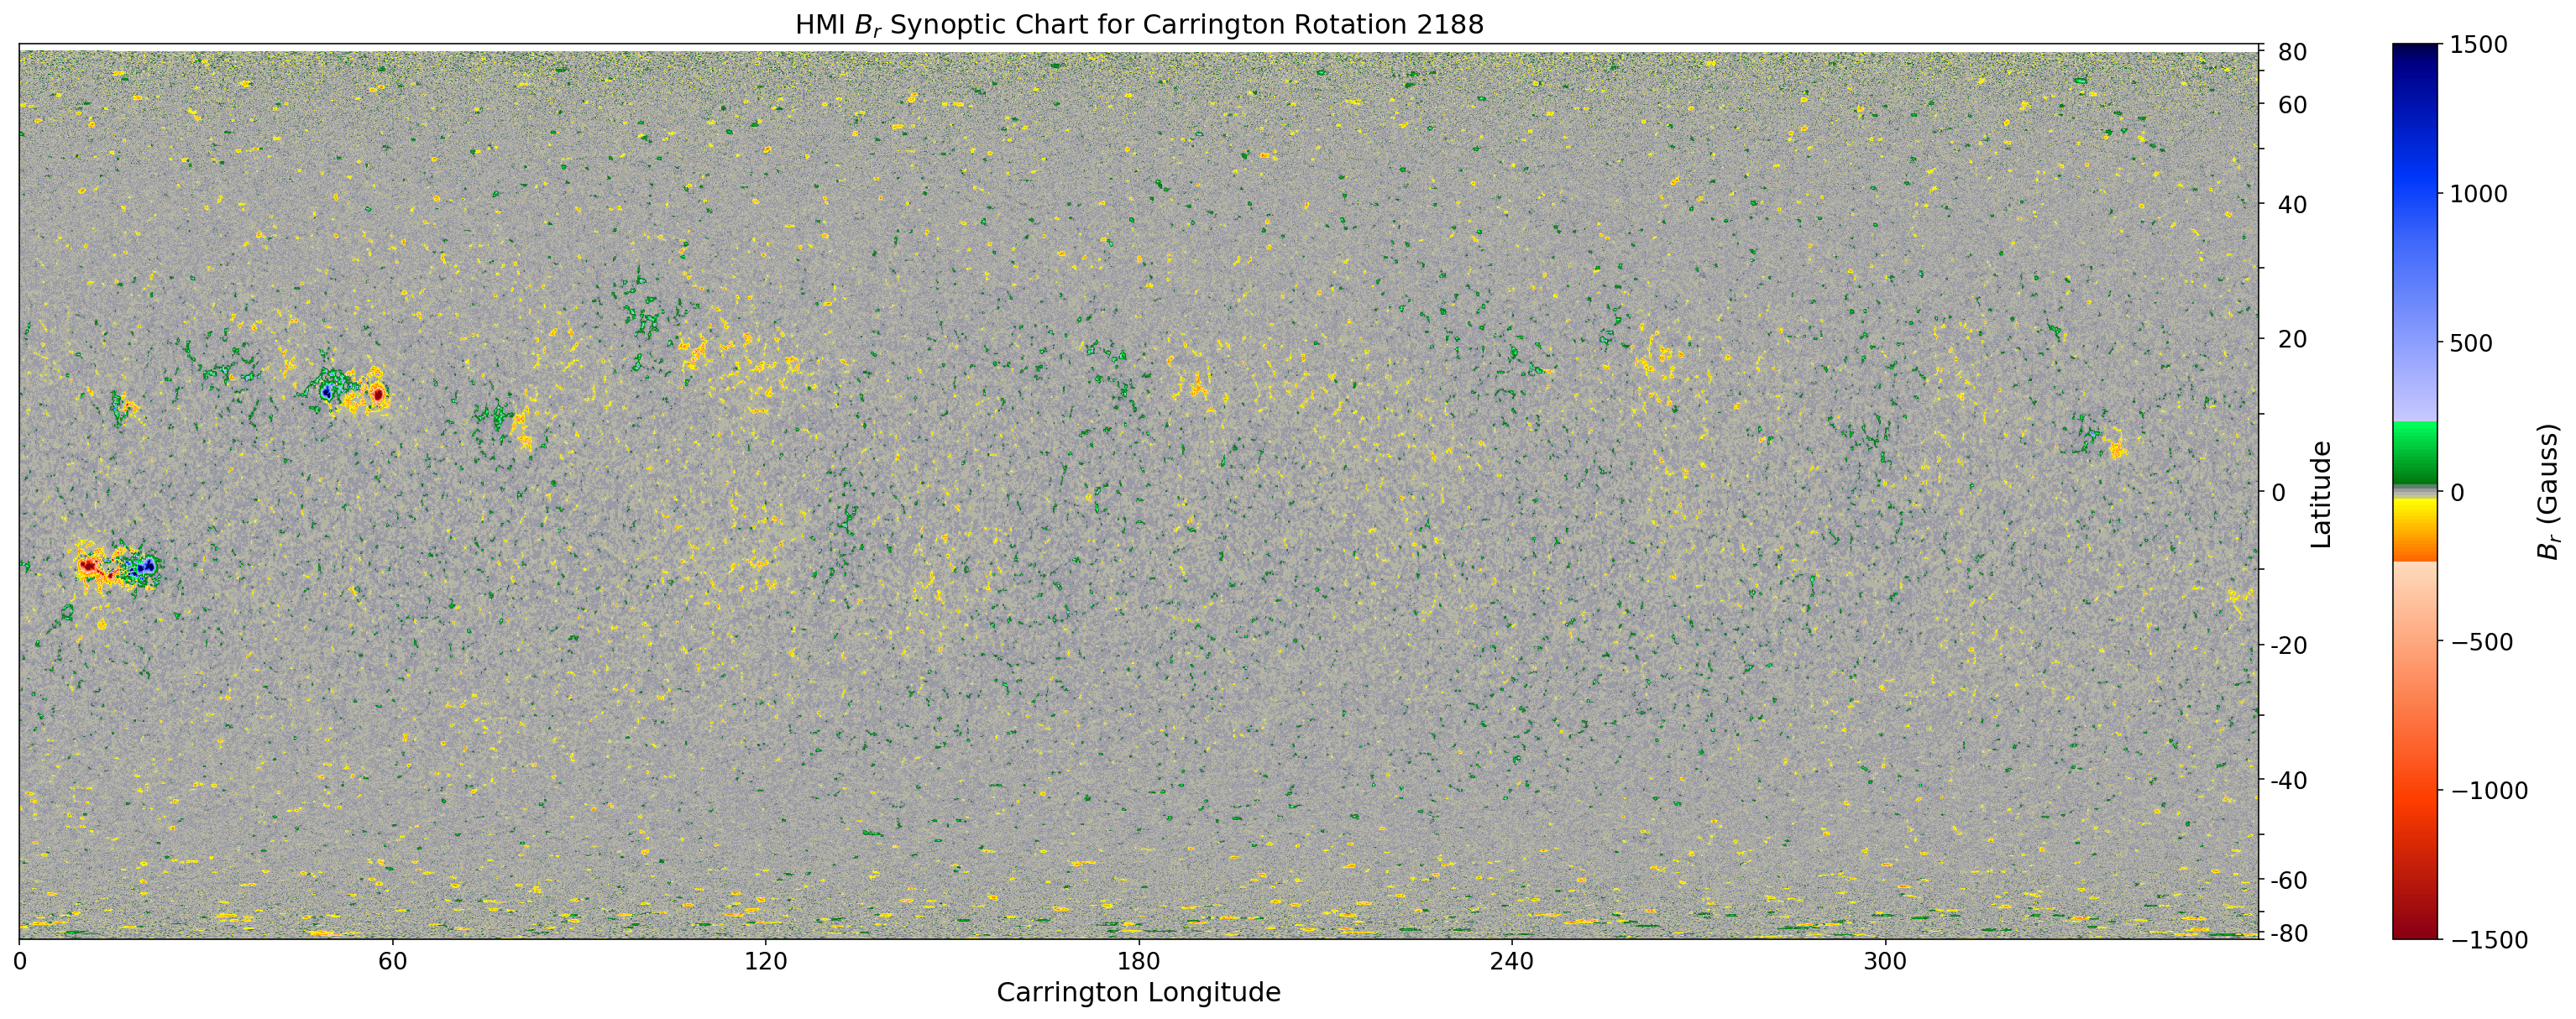

In [7]:
# make the plot
fig, ax = plt.subplots(figsize=(20,10))
fig.subplots_adjust(left=0,right=1,top=1,bottom=0)
text_style = dict(fontsize=16)
ax.tick_params(labelsize=14)
plt.imshow(br[0].data,cmap=colormap_customized,vmin=-1500,vmax=1500,origin='lower',extent=[0,3600,0,1440],interpolation='nearest')
ax.set_title('HMI $B_{r}$ Synoptic Chart for Carrington Rotation '+str(keys.CAR_ROT[0]),**text_style)
ax.tick_params(axis='both', which='both', labelbottom=True, labeltop=False, labelleft=True, labelright=True)

# label the x-axis 
xlabels = [0,60,120,180,240,300]
xlocations = [0,600,1200,1800,2400,3000]
ax.set_xticklabels(xlabels)
ax.set_xticks(xlocations)
ax.set_xlabel('Carrington Longitude',**text_style)

# Create the sine latitude labels on the left-hand side of the plot
# ylabels_l = [-1,0,1]
# ylocations_l = [0.,720.,1440.]
# ax.set_yticklabels(ylabels_l)
# ax.set_yticks(ylocations_l)
# ax.set_ylabel('Sine Latitude',**text_style)
# ax.yaxis.set_label_position("left")
# ax.yaxis.tick_left()

# Create the latitude labels on the right-hand side of the plot
ylabels_r = [' ','-80 ',' ','-60',' ','-40',' ','-20',' ','0',' ',' 20',' ',' 40',' ',' 60',' ',' 80',' ']
ylocations_r = ytick_normalize
ax.set_yticklabels(ylabels_r)
ax.set_yticks(ylocations_r)
ax.set_ylabel('Latitude',**text_style)
ax.yaxis.labelpad=-5
ax.tick_params(labelsize=14)
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()

# plot the colorbar
divider_cbar = make_axes_locatable(ax)
width_cbar = axes_size.AxesY(ax, aspect=0.05)
pad_cbar = axes_size.Fraction(3.0, width_cbar)
cax = divider_cbar.append_axes("right", size=width_cbar, pad=pad_cbar)
cax.tick_params(labelsize=14)
cbar = plt.colorbar(cax=cax)
cbar.ax.tick_params(labelsize=14)
cbar.set_label('$B_{r}$ (Gauss)', size=16)